In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
from scipy.cluster.vq import kmeans, kmeans2, whiten, vq
import sklearn
from sklearn import metrics
from scipy.spatial.distance import cdist
%matplotlib inline

In [2]:
evo_travels = pd.read_csv('../../Python Scripts/travels_id_tratado.csv')

## Useful Functions

In [3]:
def haversine(lon1, lat1, lon2, lat2):
    """
    Calculate distance between the geo coordinates
    """
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2

    c = 2 * np.arcsin(np.sqrt(a))
    m = 6367 * c * 1000

    return m

In [4]:
def plot_elbow(data, k, mark=4, title='Elbow for K-Means clustering'):
    """
    Calculates the kmeans for k number of clusters and plot a figure
    to be used the elbow method.
    """

    # Normalizing
    X = whiten(data)

    K = range(1,k)

    print('Calculating Kmeans...')
    KM = [kmeans(X,k) for k in K] # apply kmeans 1 to k
    centroids = [cent for (cent,var) in KM]   # cluster centroids

    print('Calculating distance...')
    D_k = [cdist(X, cent, 'euclidean') for cent in centroids]

    cIdx = [np.argmin(D,axis=1) for D in D_k]
    dist = [np.min(D,axis=1) for D in D_k]
    avgWithinSS = [sum(d)/X.shape[0] for d in dist]  

    print('All Done!')
    kIdx = mark - 1

    # plot elbow curve
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(K, avgWithinSS, 'b*-')
    ax.plot(K[kIdx], avgWithinSS[kIdx], marker='o', markersize=12, 
        markeredgewidth=2, markeredgecolor='r', markerfacecolor='None')
    plt.grid(True)
    plt.xlabel('Number of clusters')
    plt.ylabel('Average within-cluster sum of squares')
    tt = plt.title(title)  

    plt.show()

In [5]:
def hour_stats(data, hour):
  
    hour_data = data[data['hour'] == hour]['percentage']

    stats = {}

    stats['mean'] = hour_data.mean()
    stats['median'] = hour_data.median()
    stats['q1'] = hour_data.quantile(.25)
    stats['q3'] = hour_data.quantile(.75)
    stats['q4'] = hour_data.quantile(1)
    stats['std'] = hour_data.std()

    return stats

In [6]:
# Colors for the clusters
LABEL_COLOR_MAP = {0: '#920000',
                   1: '#004949',
                   2: '#ff6db6',
                   3: '#490092',
                   4: '#dbd100',
                   5: '#000000',
                   6: '#b66dff',
                   7: '#ffff6d'}

Raw data and divisions of North Vancouver and New Westminster

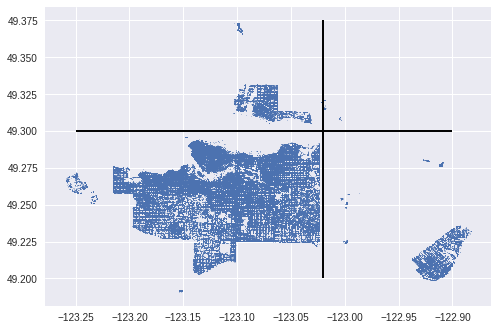

In [0]:
plt.hlines(49.3,-123.25,-122.9)
plt.vlines(-123.02,49.2,49.375)

plt.scatter(coordinates['Start_lon'], coordinates['Start_lat'], s=0.1)
plt.show()

## Data manipulation

In [7]:
evo_travels['Start_time'] = pd.to_datetime(evo_travels['Start_time'])
evo_travels['End_time'] = pd.to_datetime(evo_travels['End_time'])

# Adding a distance(m) column
evo_travels['distance'] = evo_travels.apply(lambda x: haversine(x.Start_lon,x.Start_lat,
                                                                x.End_lon,x.End_lat), axis=1)

# Columns of hour and weekday of each occurrence
evo_travels['hour'] = evo_travels['Start_time'].dt.hour
evo_travels['weekday'] = evo_travels['Start_time'].dt.weekday # 0 = Monday, 6 = Sunday

# Binary columns of daily periods
evo_travels['dawn'] = (evo_travels['hour'] < 6).astype('int')
evo_travels['morning'] = ((evo_travels['hour'] >= 6) & (evo_travels['hour'] < 12)).astype('int')
evo_travels['afternoon'] = ((evo_travels['hour'] >= 12) & (evo_travels['hour'] < 18)).astype('int')
evo_travels['night'] = ((evo_travels['hour'] >= 18) & (evo_travels['hour'] <= 23)).astype('int')

# Removing New Westminster
evo_travels = evo_travels[(evo_travels['Start_lon'] < -123.02)]
evo_travels = evo_travels[(evo_travels['End_lon'] < -123.02)]

In [8]:
evo_travels.head()

,Id,Start_time,Start_lat,Start_lon,Fuel_start,End_time,End_lat,End_lon,Fuel_end,duration,distance,hour,weekday,dawn,morning,afternoon,night
1,JTDKDTB32G1589000,2018-03-01 18:09:30.383898,49.314045,-123.083481,84,2018-03-01 18:33:40.410390,49.314045,-123.083481,84,24.167108,0.000000e+00,18,3,0,0,0,1
2,JTDKDTB32G1589000,2018-03-01 18:36:09.073847,49.314045,-123.083481,84,2018-03-01 20:24:36.451198,49.315067,-123.083481,83,108.456289,1.136032e+02,18,3,0,0,0,1
3,JTDKDTB32G1589000,2018-03-01 20:39:21.714875,49.315067,-123.083481,83,2018-03-01 21:09:48.876096,49.315067,-123.083481,83,30.452687,7.068790e-10,20,3,0,0,0,1
4,JTDKDTB32G1589000,2018-03-01 21:12:05.647857,49.315067,-123.083481,83,2018-03-01 21:15:26.307443,49.315067,-123.083481,83,3.344326,7.068790e-10,21,3,0,0,0,1
5,JTDKDTB32G1589000,2018-03-01 21:18:46.154800,49.315067,-123.083481,83,2018-03-01 21:33:18.854778,49.327805,-123.081482,83,14.545000,1.422821e+03,21,3,0,0,0,1


## Finding the optimal number of clusters for weekdays and weekends

In [9]:
labels = ['Start_lat', 'Start_lon', 'Fuel_start', 'End_lat',
          'End_lon', 'Fuel_end', 'duration', 'distance',
          'dawn', 'morning', 'afternoon', 'night']

weekdays = evo_travels[evo_travels['weekday'] < 5][labels]
weekends = evo_travels[evo_travels['weekday'] >= 5][labels]

Weekdays:

Calculating Kmeans...
Calculating distance...
All Done!


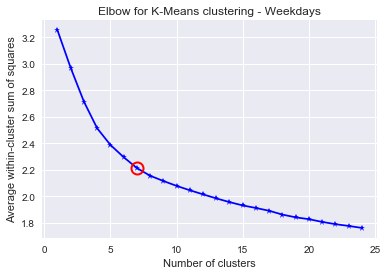

In [10]:
plot_elbow(weekdays, 25, mark=7, title='Elbow for K-Means clustering - Weekdays')

For weekdays will be choose 7 clusters

Weekends:

Calculating Kmeans...
Calculating distance...
All Done!


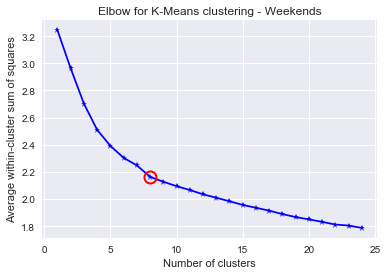

In [9]:
plot_elbow(weekends, 25, mark=8, title='Elbow for K-Means clustering - Weekends')

For weekends will be choose 8 clusters

## Plotting the clusterization

Weekdays:

In [10]:
x, y = kmeans2(whiten(weekdays), 7, iter = 20)

In [11]:
# Column with groups
weekdays['cluster'] = y

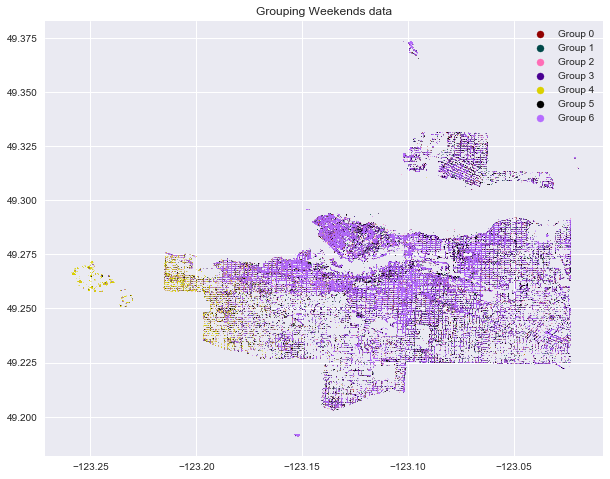

In [12]:
plt.figure(figsize=(10,8))

groups = weekdays['cluster'].unique()
groups.sort()

for g in groups:
    group_data = weekdays[weekdays['cluster'] == g]
    plt.scatter(group_data['Start_lon'], group_data['Start_lat'], c=LABEL_COLOR_MAP[g], s=0.1, label='Group '+str(g))

plt.title('Grouping Weekends data')

# Changing the size of legend point
legend = plt.legend()
for g in groups:
    legend.legendHandles[g]._sizes = [50]

plt.show()

Weekends:

In [13]:
x, y = kmeans2(whiten(weekends), 8, iter = 20, minit='points')

In [14]:
# Column with groups
weekends['cluster'] = y

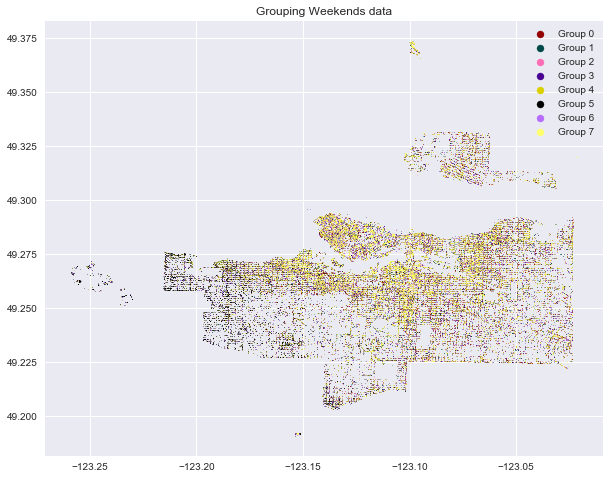

In [15]:
plt.figure(figsize=(10,8))

groups = weekends['cluster'].unique()
groups.sort()

for g in groups:
    group_data = weekends[weekends['cluster'] == g]
    plt.scatter(group_data['Start_lon'], group_data['Start_lat'], c=LABEL_COLOR_MAP[g], s=0.1, label='Group '+str(g))

plt.title('Grouping Weekends data')

# Changing the size of legend point
legend = plt.legend()
for g in groups:
    legend.legendHandles[g]._sizes = [50]

plt.show()

## Creating a data structure of regions that have more concetration of a cluster:

In [16]:
# Creating points of Vancouver region
latitudes = []
longitudes = []
for lat in np.arange(49.18,49.38,0.003):
    for lon in np.arange(-123.26,-123.02,0.003):
        latitudes.append(lat)
        longitudes.append(lon)
        
points = pd.DataFrame({'lon':longitudes, 'lat':latitudes})

Visualizing this points:

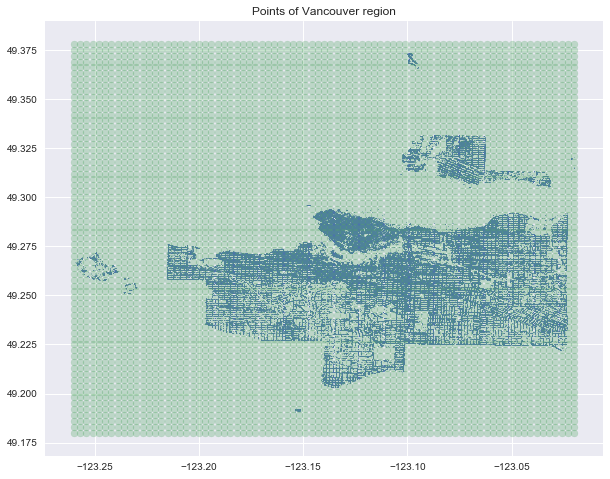

In [18]:
plt.figure(figsize=(10,8))
plt.scatter(evo_travels['Start_lon'], evo_travels['Start_lat'], s=0.1)
plt.scatter(points['lon'], points['lat'], alpha=0.3)
plt.title('Points of Vancouver region')

plt.show()

In [17]:
def geojson_builder(down_left,up_right,group):
    """
    Build a rectangle geojson from two points.
    """
    p1 = [str(down_left[0]),str(down_left[1])]
    p2 = [str(up_right[0]),str(down_left[1])]
    p3 = [str(up_right[0]),str(up_right[1])]
    p4 = [str(down_left[0]),str(up_right[1])]
    
    geojson = {"type": "FeatureCollection",
              "features": [
                {"type": "Feature",
                    "properties":{
                        "group": str(group)
                    },
                    "geometry": {
                        "type": "Polygon",
                        "coordinates": [[p1,p2,p3,p4,p1]] }}]}

    return geojson

In [18]:
def build_regions(data, points):
    """
    Create a list of geojsons that represent the group more 
    significant in the region.
    """
  
    # Creating matrix of the region coordinates
    # matrix dimensions based in points
    lat = points['lat'].unique()
    step = round(abs(lat[0]-lat[1]),5)
    diff = abs(lat.max() - lat.min())

    len_y = int(diff/step)+1

    lon = points['lon'].unique()
    step = round(abs(lon[0]-lon[1]),5)
    diff = abs(lon.max() - lon.min())

    len_x = int(diff/step)+1
    
    
    matrix = []

    # filling the matrix with the points coordinates
    c = 0
    for y in range(len_y):
        line = []
        for x in range(len_x):
            line.append((points['lon'].iloc[c], points['lat'].iloc[c]))
            c+=1
        matrix.append(line)

    geojsons = []
    
    # Column options for travels and idle datasets
    lat_column = 'lat'
    lon_column = 'lon'
    if not data.columns.isin([lat_column,lon_column]).any():
        lat_column = 'Start_lat'
        lon_column = 'Start_lon'
    
    for lin in range(len(matrix)-1):
        for col in range(len(matrix[0])-1):

            # Selecting all points inside a square of matrix coordinates
            down_left = matrix[lin][col]
            up_right = matrix[lin+1][col+1]
            
            lon_condition = (data[lon_column] >= down_left[0]) & (data[lon_column] <= up_right[0])
            lat_condition = (data[lat_column] >= down_left[1]) & (data[lat_column] <= up_right[1])

            travels = data.loc[lon_condition & lat_condition]

            if len(travels) != 0:
                # Build a geojson of the group more significant in the square
                group = travels['cluster'].value_counts().index[0]
                geojsons.append(geojson_builder(down_left,up_right,group))
                
                # Changing group of the other travels
                data.loc[lon_condition & lat_condition, 'cluster'] = [group]*len(travels)

            
    return geojsons

In [19]:
def plot_regions(geo_jsons):
    """
    Plot a map of the regions.
    """
    
    plt.figure(figsize=(10,8))
    fig, ax = plt.subplots()
    
    group_set = set()
    
    for json in geo_jsons:
        coords = json['features'][0]['geometry']['coordinates'][0]
        group = int(json['features'][0]['properties']['group'])
        
        group_set.add(group) # Store the group of the plots for legend
        
        x = [i for i,j in coords]
        y = [j for i,j in coords]
        
        plt.fill(x,y, color=LABEL_COLOR_MAP[group])
        
    # Legend for each group
    legend_patches = []
    for g in group_set:
        legend_patches.append(mpatches.Patch(color=LABEL_COLOR_MAP[g], label='Group '+str(g)))
    
    plt.legend(handles=legend_patches)
    plt.tight_layout()
    
    plt.show()

In [20]:
weekdays_geojsons = build_regions(weekdays, points)
weekends_geojsons = build_regions(weekends, points)

Weekdays regions:

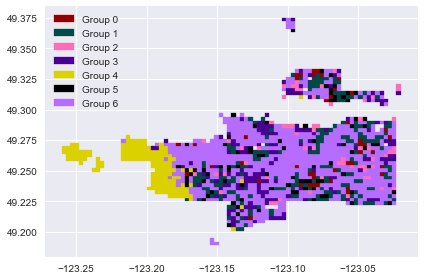

In [21]:
plot_regions(weekdays_geojsons)

Weekends regions:

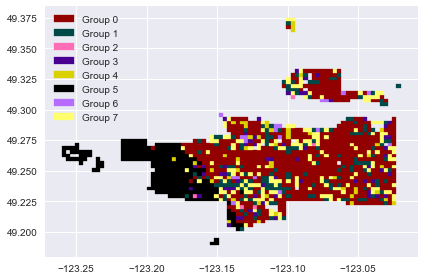

In [22]:
plot_regions(weekends_geojsons)

## Weekdays and Weekends data status

In [23]:
def count_busy(df, period):
    """
    Count business activity of each occurence of the dataframe in the 
    period.
    """

    busy = []
    idle = []

    # Vehicle id list in order to make a percentage of busy cars in each minute
    car_ids = df.Id.unique()
    n_cars = len(car_ids)

    # Going through each collected minute
    for dt in period:
        # Counting the number of travels that this minute is included
        in_travel = len(df[(df['Start_time'] <= dt) & (dt < df['End_time'])].Id.unique())
        percentage = (in_travel/n_cars) * 100

        busy.append([dt, in_travel, percentage])

    return pd.DataFrame(busy, columns=['capture_time','count','percentage'])

In [24]:
# Bring back the start time, end time and Id column
merge_labels = labels + ['Start_time', 'End_time', 'Id']

weekdays = pd.merge(weekdays, evo_travels[merge_labels], on=labels)
weekends = pd.merge(weekends, evo_travels[merge_labels], on=labels)

In [25]:
busy_weekdays = count_busy(weekdays,weekdays.Start_time.unique())
busy_weekends = count_busy(weekends,weekends.Start_time.unique())

busy_weekdays['hour'] = busy_weekdays.capture_time.dt.hour
busy_weekends['hour'] = busy_weekends.capture_time.dt.hour

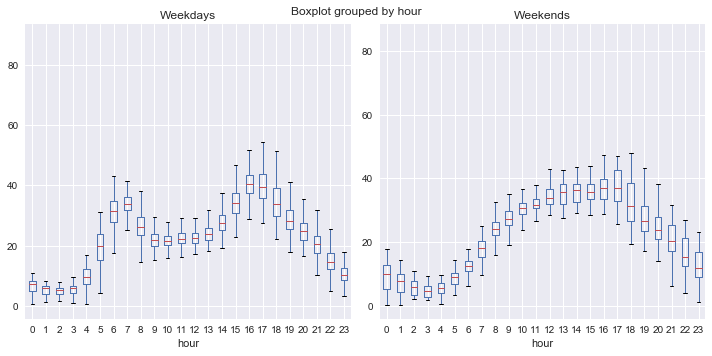

In [26]:
fig, (ax1,ax2) = plt.subplots(nrows=1,ncols=2)
fig.set_size_inches(10,5)

busy_weekdays.boxplot(column='percentage',by='hour',ax=ax1)
ax1.set_title('Weekdays')

busy_weekends.boxplot(column='percentage',by='hour',ax=ax2)
ax2.set_title('Weekends')


fig.tight_layout()
plt.show()

## Data status of each group

In [25]:
def plot_boxplots(data, nrows, ncols, figsize, ylim=50):
    
    groups = data['cluster'].unique()
    groups.sort()
    
    busy_list = []
    for g in groups:
        travels_group = data[data['cluster'] == g]

        busy_group = count_busy(travels_group,travels_group.Start_time.unique())
        busy_group['hour'] = busy_group.capture_time.dt.hour

        busy_list.append(busy_group)
    
    fig, axarr = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
    fig.subplots_adjust(left=0.03, right=0.97, hspace=0.3, wspace=0.5, top=0.7)
    c = 0
    l = 0

    for g, busy_group in zip(groups, busy_list):
    
        busy_group.boxplot(column='percentage',by='hour',ax=axarr[l, c])

        plt.ylim(0,1)

        axarr[l, c].set_title('Group = '+str(g))
        axarr[l, c].set_ylim(0,ylim)

        c+=1
        if (c >= ncols): # aux variables to plot in matrix format
            c = 0
            l += 1

    plt.tight_layout()
    plt.show()

Weekdays:

In [26]:
groups = weekdays['cluster'].unique()
groups.sort()

In [27]:
busy_list = []
for g in groups:
    travels_group = weekdays[weekdays['cluster'] == g]
    
    busy_group = count_busy(travels_group,travels_group.Start_time.unique())
    busy_group['hour'] = busy_group.capture_time.dt.hour
    
    busy_list.append(busy_group)

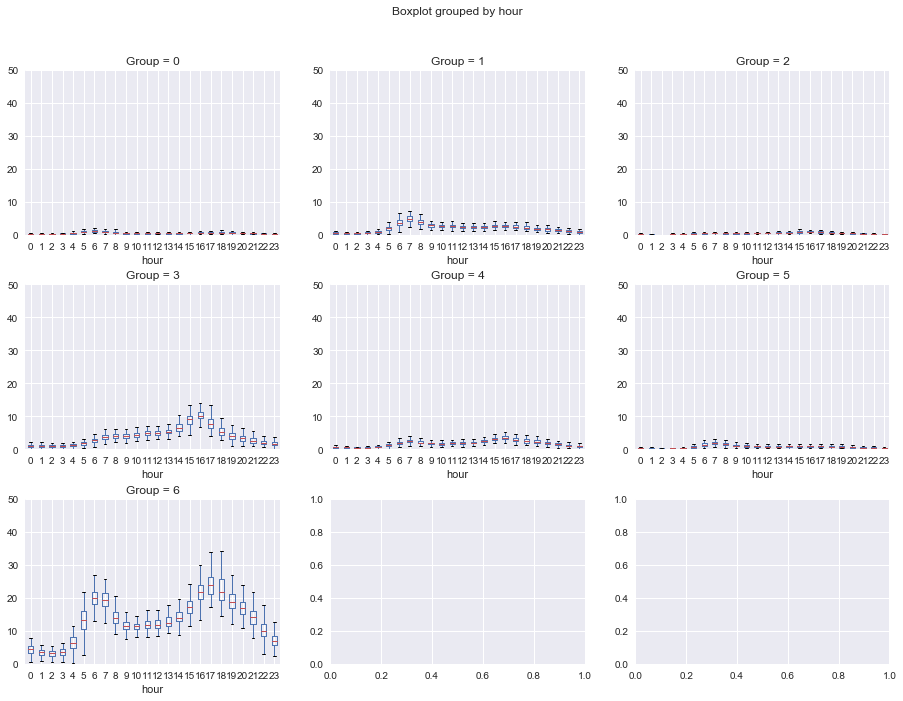

In [28]:
fig, axarr = plt.subplots(nrows=3, ncols=3, figsize=(15,11))
fig.subplots_adjust(left=0.03, right=0.97, hspace=0.3, wspace=0.5, top=0.7)
c = 0
l = 0

for g, busy_group in zip(groups, busy_list):
    
    busy_group.boxplot(column='percentage',by='hour',ax=axarr[l, c])
    
    axarr[l, c].set_title('Group = '+str(g))
    axarr[l, c].set_ylim(0,50)
    
    c+=1
    if (c >= 3): # aux variables to plot in matrix format
        c = 0
        l += 1

plt.show()

Weekends:

In [29]:
groups = weekends['cluster'].unique()
groups.sort()

In [30]:
busy_list = []
for g in groups:
    travels_group = weekends[weekends['cluster'] == g]
    
    busy_group = count_busy(travels_group,travels_group.Start_time.unique())
    busy_group['hour'] = busy_group.capture_time.dt.hour
    
    busy_list.append(busy_group)

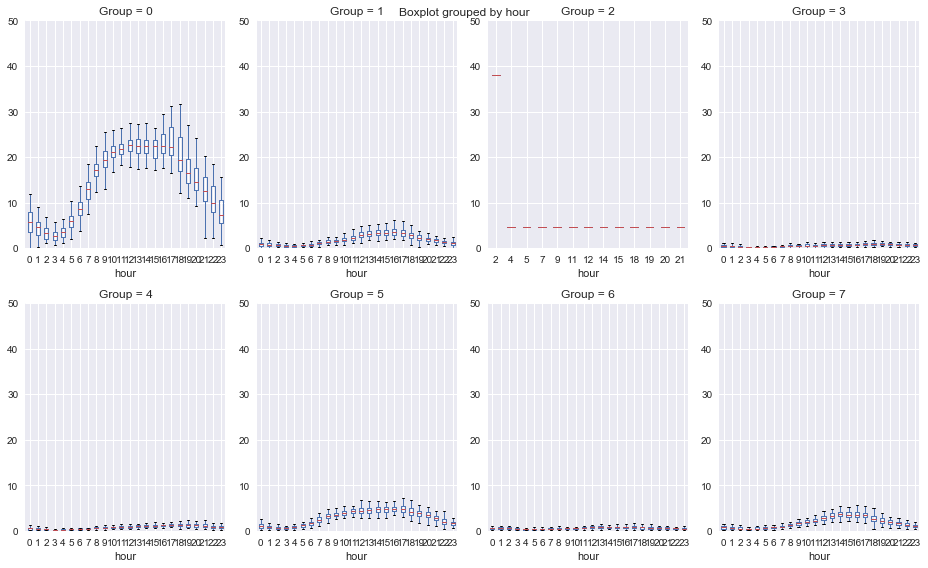

In [31]:
fig, axarr = plt.subplots(nrows=2, ncols=4, figsize=(13, 8))
fig.subplots_adjust(left=0.03, right=0.97, hspace=0.3, wspace=0.5, top=0.3)
c = 0
l = 0

for g, busy_group in zip(groups, busy_list):
    
    busy_group.boxplot(column='percentage',by='hour',ax=axarr[l, c])
    
    axarr[l, c].set_title('Group = '+str(g))
    axarr[l, c].set_ylim(0,50)
    
    c+=1
    if (c >= 4): # aux variables to plot in matrix format
        c = 0
        l += 1

plt.tight_layout()
plt.show()

## Analysing duration, distance and fuel use of the groups

### Distance:

In [32]:
def cdf(df, column):
    """
    Calcula valores de todas as coordenadas (x,y) para uma CDF.
    
    Parameters
    -----------
    df : float list, pandas.DataFrame
        Lista de valores de durações para ser feita a CDF.
    
    Returns
    ---------
    x, y: float list
        Lista de todas as coordenadas da CDF.
        
    """
    
    df = df.sort_values(by=column)
    values = df[column]
    
    x = []
    y = []

    total = float(len(values))
    cnt = 0
    last = values.iloc[0]
    for data in values:
        if data != last:
            x.append(last)
            y.append(cnt/total)
            
            cnt += 1
            last = data
        else:
            cnt += 1
    x.append(last)
    y.append(cnt/total)
    
    return x, y

In [33]:
def plot_cdf(data, column, xscale='linear', title=''):
    groups = data['cluster'].unique()
    groups.sort()
    
    for g in groups:

        group_data = data[data['cluster'] == g]

        x, y = cdf(group_data.copy(), column)
        plt.plot(x,y, color=LABEL_COLOR_MAP[g], label='Group '+str(g))

    plt.ylim(0,1)
    plt.xscale(xscale)
    
    plt.legend(loc=4, borderaxespad=0.2, frameon=False)
    plt.title(title)
    plt.tight_layout()
    plt.show()

In [34]:
def plot_cdf_matrix(data, column, nrows, ncols, figsize, xscale='linear'):
    
    groups = data['cluster'].unique()
    groups.sort()
    
    fig, axarr = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
    fig.subplots_adjust(left=0.03, right=0.97, hspace=0.3, wspace=0.5, top=0.7)
    c = 0
    l = 0

    for g in groups:

        group_data = data[data['cluster'] == g]

        x, y = cdf(group_data.copy(), column)
        axarr[l, c].plot(x,y, color=LABEL_COLOR_MAP[g])

        plt.ylim(0,1)

        axarr[l, c].set_title('Group = '+str(g))
        if (column == 'distance'):
            axarr[l, c].set_xlim(0,20000)
        axarr[l, c].set_ylim(0,1)
        axarr[l, c].set_xscale(xscale)

        c+=1
        if (c >= ncols): # aux variables to plot in matrix format
            c = 0
            l += 1

    plt.tight_layout()
    plt.show()

Weekdays:

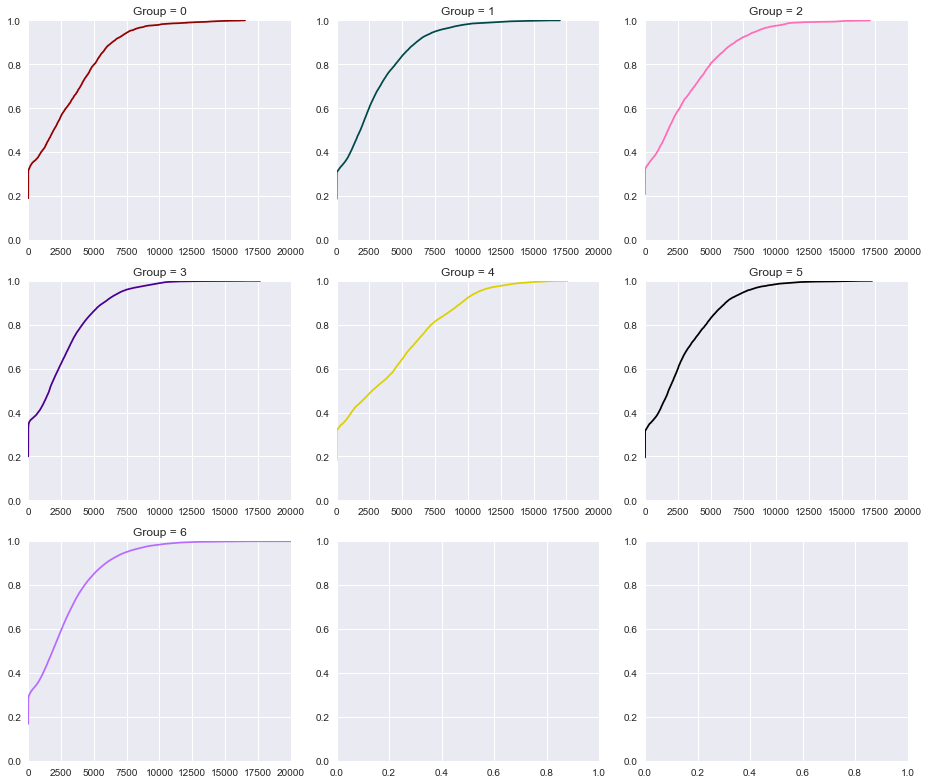

In [35]:
plot_cdf_matrix(weekdays, 'distance', 3, 3, (13,11))

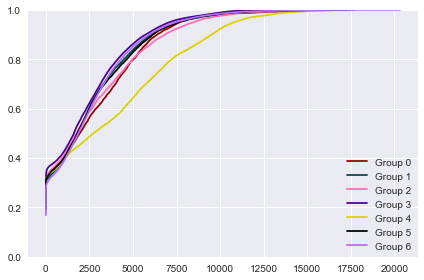

In [36]:
plot_cdf(weekdays, 'distance')

Weekends:

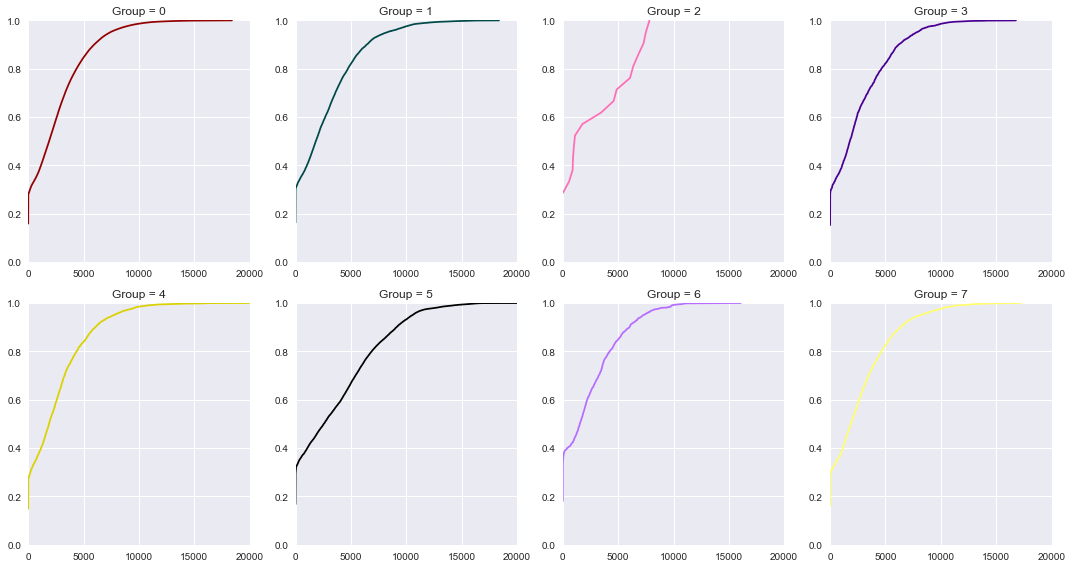

In [37]:
plot_cdf_matrix(weekends, 'distance', 2, 4, (15,8))

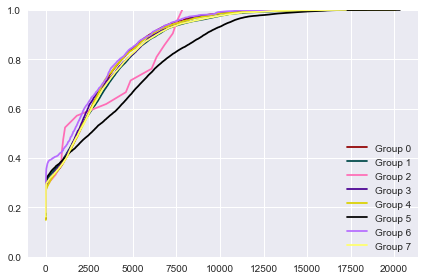

In [38]:
plot_cdf(weekends, 'distance')

### Duration:

Weekdays:

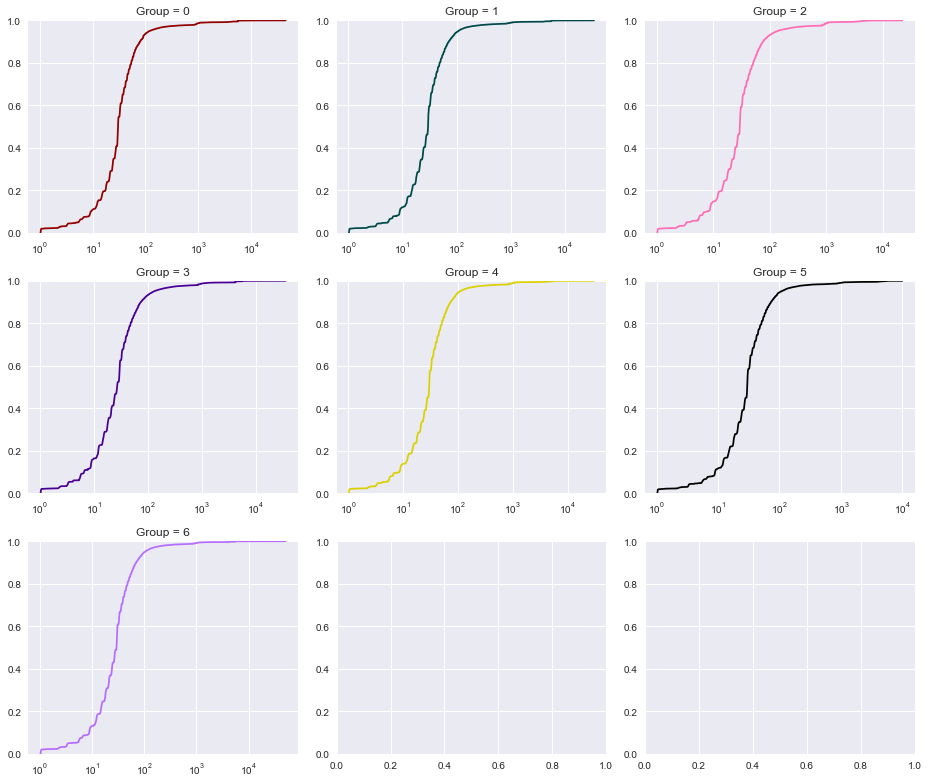

In [39]:
plot_cdf_matrix(weekdays, 'duration', 3, 3, (13,11), xscale='log')

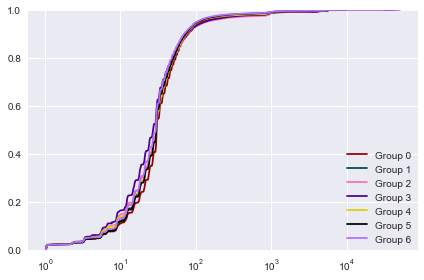

In [40]:
plot_cdf(weekdays, 'duration', 'log')

Weekends:

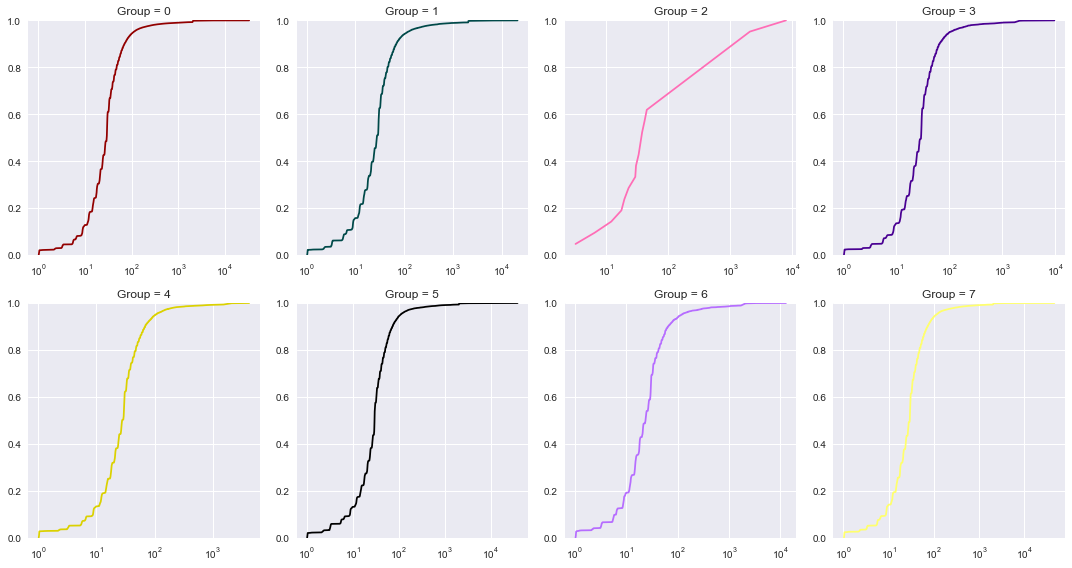

In [41]:
plot_cdf_matrix(weekends, 'duration', 2, 4, (15,8), xscale='log')

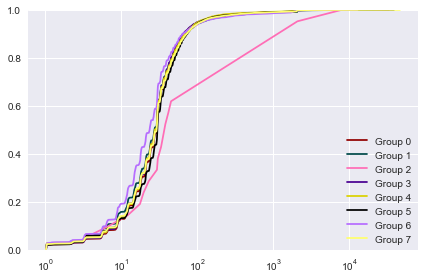

In [42]:
plot_cdf(weekends, 'duration', 'log')

### Fuel use:

Weekdays:

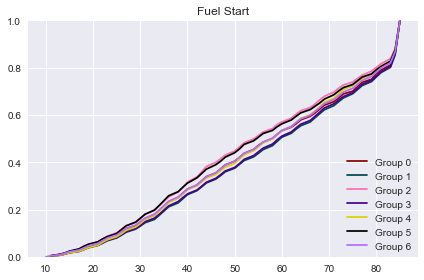

In [43]:
plot_cdf(weekdays, 'Fuel_start', title='Fuel Start')

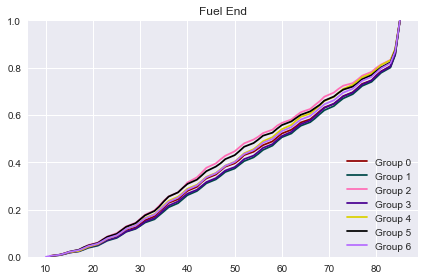

In [44]:
plot_cdf(weekdays, 'Fuel_end', title='Fuel End')

Weekends:

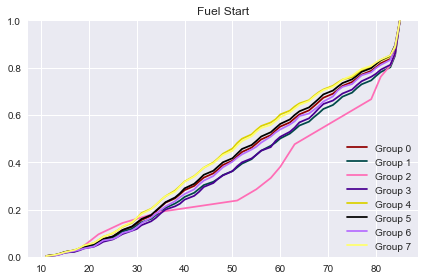

In [45]:
plot_cdf(weekends, 'Fuel_start', title='Fuel Start')

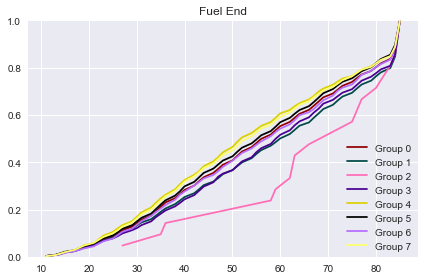

In [46]:
plot_cdf(weekends, 'Fuel_end', title='Fuel End')

## Analysis of Idle period

### Data manipulation

In [47]:
# Creating a parked duration dataframe
parked_list = []
car_ids = evo_travels.Id.unique()

for id in car_ids:
    # Selecting all the data from each car
    car = evo_travels[evo_travels['Id'] == id]
    car = car.sort_values(by='Start_time')
    
    for i in range(1, len(car)):
        duration = car['Start_time'].iloc[i] - car['End_time'].iloc[i-1] 
        duration = duration.total_seconds()/60
        parked_list.append([id, car['End_time'].iloc[i-1], car['Start_time'].iloc[i], 
                            car['Start_lon'].iloc[i], car['Start_lat'].iloc[i], duration])

evo_idle = pd.DataFrame(parked_list, columns=['Id', 'Start_time', 'End_time', 'lon', 'lat', 'duration'])

In [48]:
# Columns of hour and weekday of each occurrence
evo_idle['hour'] = evo_idle['Start_time'].dt.hour
evo_idle['weekday'] = evo_idle['Start_time'].dt.weekday # 0 = Monday, 6 = Sunday

# Binary columns of daily periods
evo_idle['dawn'] = (evo_idle['hour'] < 6).astype('int')
evo_idle['morning'] = ((evo_idle['hour'] >= 6) & (evo_idle['hour'] < 12)).astype('int')
evo_idle['afternoon'] = ((evo_travels['hour'] >= 12) & (evo_idle['hour'] < 18)).astype('int')
evo_idle['night'] = ((evo_idle['hour'] >= 18) & (evo_idle['hour'] <= 23)).astype('int')

In [49]:
evo_idle.head()

,Id,Start_time,End_time,lon,lat,duration,hour,weekday,dawn,morning,afternoon,night
0,JTDKDTB32G1589000,2018-03-01 18:33:40.410390,2018-03-01 18:36:09.073847,-123.083481,49.314045,2.477724,18,3,0,0,0,1
1,JTDKDTB32G1589000,2018-03-01 20:24:36.451198,2018-03-01 20:39:21.714875,-123.083481,49.315067,14.754395,20,3,0,0,0,1
2,JTDKDTB32G1589000,2018-03-01 21:09:48.876096,2018-03-01 21:12:05.647857,-123.083481,49.315067,2.279529,21,3,0,0,0,1
3,JTDKDTB32G1589000,2018-03-01 21:15:26.307443,2018-03-01 21:18:46.154800,-123.083481,49.315067,3.330789,21,3,0,0,0,1
4,JTDKDTB32G1589000,2018-03-01 21:33:18.854778,2018-03-02 04:36:32.122512,-123.081482,49.327805,423.221129,21,3,0,0,0,1


In [50]:
labels = ['lat', 'lon', 'duration',
          'dawn', 'morning', 'afternoon', 'night']

weekdays_idle = evo_idle[evo_idle['weekday'] < 5][labels]
weekends_idle = evo_idle[evo_idle['weekday'] >= 5][labels]

### Finding the optimal number of clusters for weekdays and weekends

Weekdays:

Calculating Kmeans...
Calculating distance...
All Done!


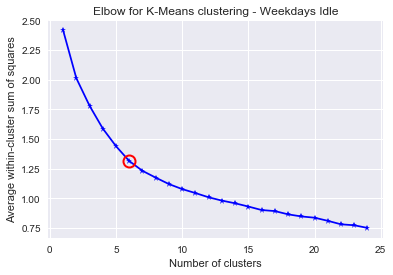

In [109]:
plot_elbow(weekdays_idle, 25, mark=6, title='Elbow for K-Means clustering - Weekdays Idle')

Weekends:

Calculating Kmeans...
Calculating distance...
All Done!


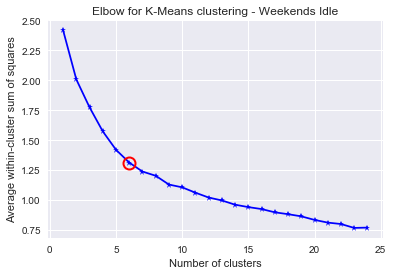

In [110]:
plot_elbow(weekends_idle, 25, mark=6, title='Elbow for K-Means clustering - Weekends Idle')

### Plotting the clusterization

In [51]:
x, y = kmeans2(whiten(weekdays_idle), 6, iter = 20)

In [52]:
weekdays_idle['cluster'] = y

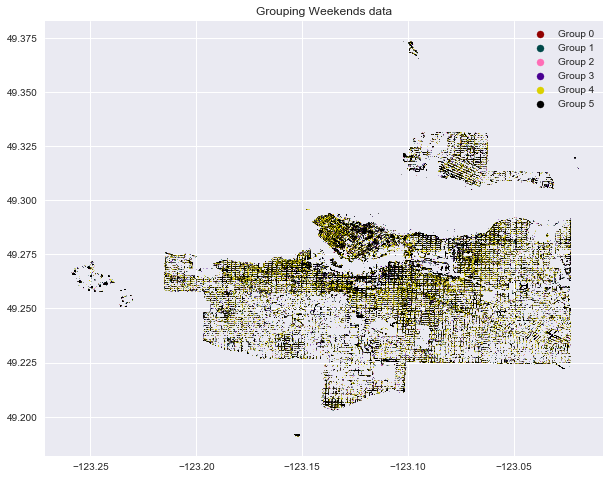

In [53]:
plt.figure(figsize=(10,8))

groups = weekdays_idle['cluster'].unique()
groups.sort()

for g in groups:
    group_data = weekdays_idle[weekdays_idle['cluster'] == g]
    plt.scatter(group_data['lon'], group_data['lat'], c=LABEL_COLOR_MAP[g], s=0.1, label='Group '+str(g))

plt.title('Grouping Weekends data')

# Changing the size of legend point
legend = plt.legend()
for g in groups:
    legend.legendHandles[g]._sizes = [50]

plt.show()

In [54]:
x, y = kmeans2(whiten(weekends_idle), 6, iter = 20)

In [55]:
weekends_idle['cluster'] = y

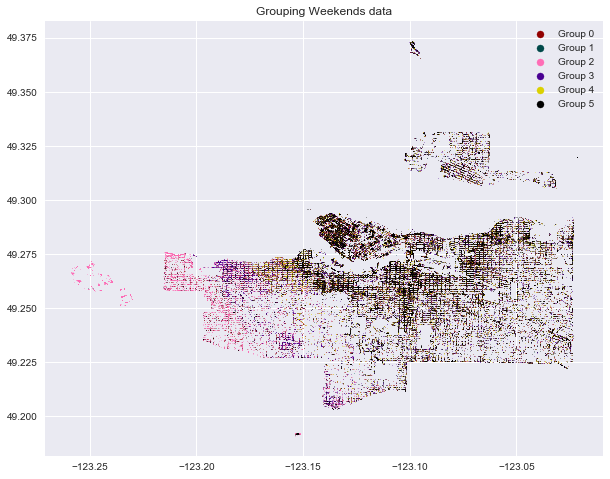

In [56]:
plt.figure(figsize=(10,8))

groups = weekends_idle['cluster'].unique()
groups.sort()

for g in groups:
    group_data = weekends_idle[weekends_idle['cluster'] == g]
    plt.scatter(group_data['lon'], group_data['lat'], c=LABEL_COLOR_MAP[g], s=0.1, label='Group '+str(g))

plt.title('Grouping Weekends data')

# Changing the size of legend point
legend = plt.legend()
for g in groups:
    legend.legendHandles[g]._sizes = [50]

plt.show()

### Creating a data structure of regions that have more concetration of a cluster

In [57]:
weekdays_idle_geojsons = build_regions(weekdays_idle, points)
weekends_idle_geojsons = build_regions(weekends_idle, points)

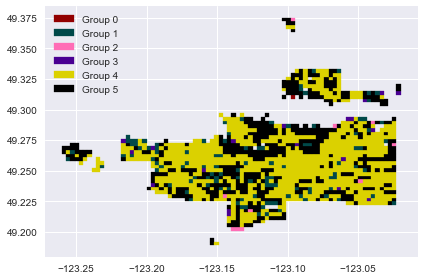

In [58]:
plot_regions(weekdays_idle_geojsons)

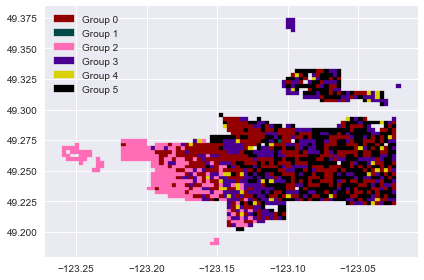

In [59]:
plot_regions(weekends_idle_geojsons)

### Data status of each group

In [60]:
# Bring back the start time, end time and Id column
merge_labels = labels + ['Start_time', 'End_time', 'Id']

weekdays_idle = pd.merge(weekdays_idle, evo_idle[merge_labels], on=labels)
weekends_idle = pd.merge(weekends_idle, evo_idle[merge_labels], on=labels)

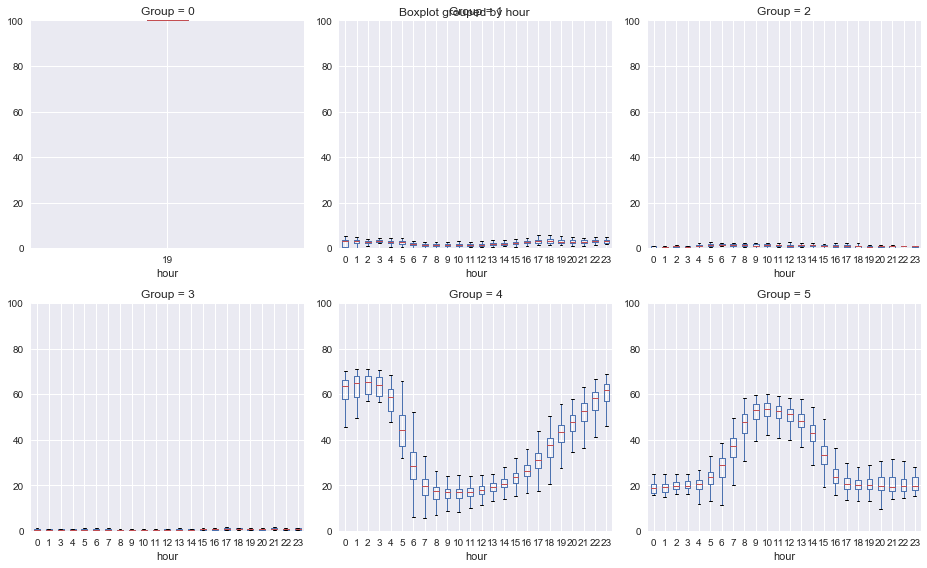

In [64]:
plot_boxplots(weekdays_idle, 2, 3, (13,8), ylim=100)

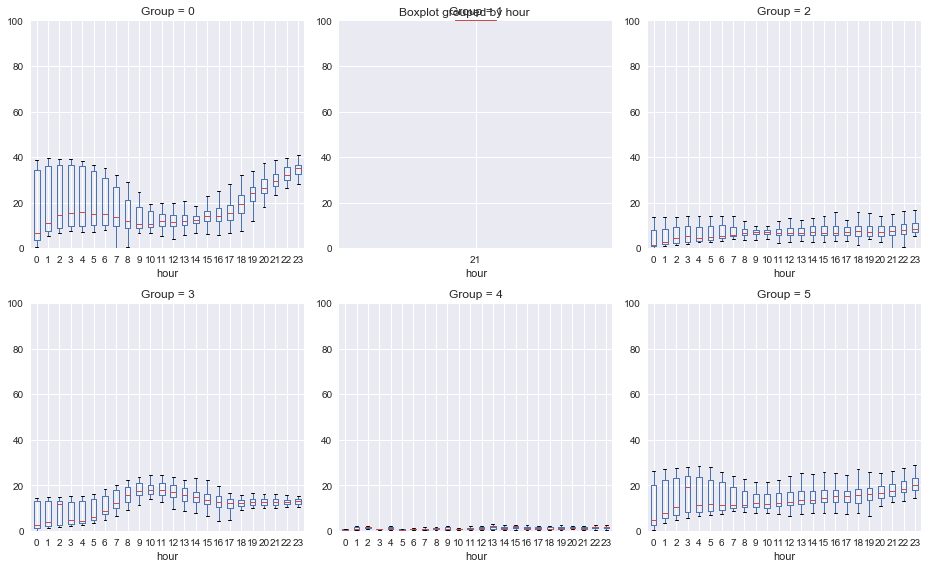

In [65]:
plot_boxplots(weekends_idle, 2, 3, (13,8), ylim=100)

### Duration analysis

Weekdays:

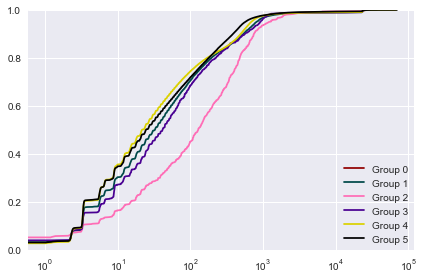

In [66]:
plot_cdf(weekdays_idle, 'duration', 'log')

Weekends:

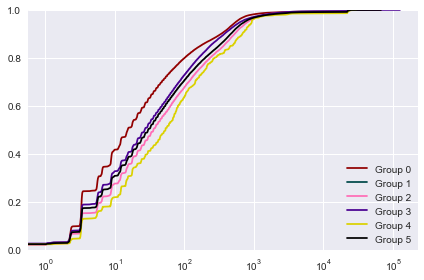

In [67]:
plot_cdf(weekends_idle, 'duration', 'log')

### Fontes

* clusterização de viagens de bike in ny: https://chih-ling-hsu.github.io/2018/01/02/clustering-python
* clusterização basica de coordenadas: https://datascience.stackexchange.com/questions/761/clustering-geo-location-coordinates-lat-long-pairs
* aplicação do metodo elbow: https://nbviewer.jupyter.org/github/nborwankar/LearnDataScience/blob/master/notebooks/D3.%20K-Means%20Clustering%20Analysis.ipynb